# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

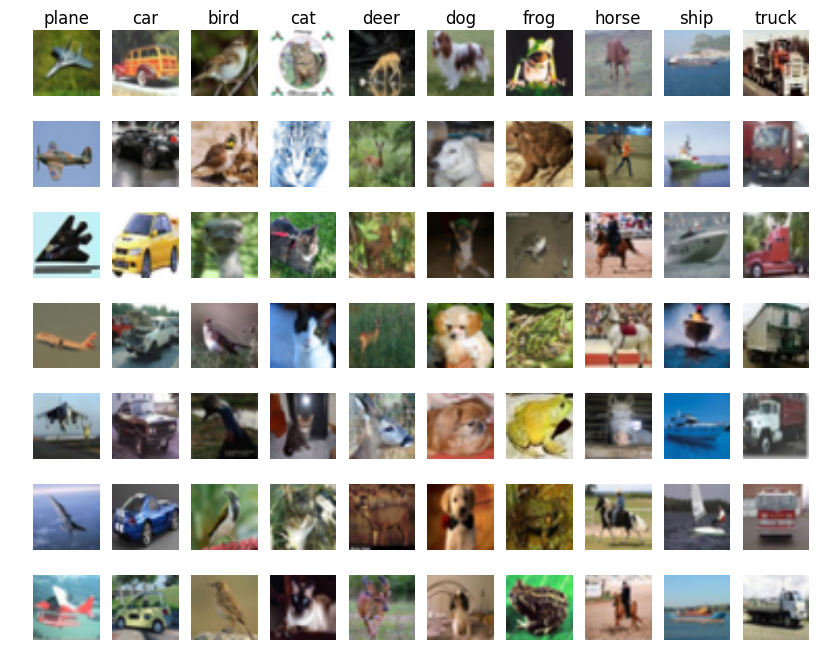

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


Так задаётся архитектура нейронки

In [5]:
a = np.zeros((32, 32, 3))
print a.shape
b = a.reshape((3, 32, 32))
print b.shape

(32, 32, 3)
(3, 32, 32)


In [6]:
X_train1 = [x for x in X_train]
for i in range(len(X_train)):
    b = X_train[i]
    X_train1[i] = b.reshape((3, 32, 32))
X_train1 = np.array(X_train1)
print X_train1.shape

(50000, 3, 32, 32)


In [61]:
input_layer = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
conv1 = lasagne.layers.Conv2DLayer(input_layer, num_filters = 10, filter_size = (3, 3))
pool1 = lasagne.layers.MaxPool2DLayer(conv1, pool_size = (2, 2))
# Для вдохновления 
# - http://torch.ch/blog/2015/07/30/cifar.html
# - http://www.robots.ox.ac.uk/~vgg/research/very_deep/
# - https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
dense1 = lasagne.layers.DenseLayer(pool1, num_units = 100, nonlinearity = sigmoid)
dense_output = lasagne.layers.DenseLayer(dense1, num_units = 10, nonlinearity=softmax)

In [62]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [63]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [64]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

In [72]:
updates_sgd = lasagne.updates.adam(loss, all_weights,learning_rate=0.05)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates_sgd, allow_input_downcast = True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast = True)

### Вот и всё, пошли её учить

In [73]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [74]:
print X_train1.shape, input_layer.shape

(50000, 3, 32, 32) (None, 3, 32, 32)


In [75]:
X_test1 = [x for x in X_test]
for i in range(len(X_test1)):
    X_test1[i] = X_test[i].reshape((3, 32, 32))
X_test1 = np.array(X_test1)
print X_test1.shape

(10000, 3, 32, 32)


In [ ]:
import time

num_epochs = 300 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train1, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test1, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 300 took 11.908s
  training loss (in-iteration):		2.590728
  train accuracy:		10.32 %
  validation accuracy:		10.30 %
Epoch 2 of 300 took 12.094s
  training loss (in-iteration):		2.479678
  train accuracy:		10.32 %
  validation accuracy:		10.30 %
Epoch 3 of 300 took 12.093s
  training loss (in-iteration):		2.473484
  train accuracy:		10.31 %
  validation accuracy:		10.30 %
Epoch 4 of 300 took 12.092s
  training loss (in-iteration):		2.472330
  train accuracy:		10.33 %
  validation accuracy:		10.30 %
Epoch 5 of 300 took 12.093s
  training loss (in-iteration):		2.471844
  train accuracy:		10.32 %
  validation accuracy:		10.30 %
Epoch 6 of 300 took 12.102s
  training loss (in-iteration):		2.471570
  train accuracy:		10.33 %
  validation accuracy:		10.30 %
Epoch 7 of 300 took 12.100s
  training loss (in-iteration):		2.471476
  train accuracy:		10.33 %
  validation accuracy:		10.30 %
Epoch 8 of 300 took 12.101s
  training loss (in-iteration):		2.471397
  train accuracy:		10.33 %


In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3